In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

from netcal.metrics import ECE
import robustness_metrics as rm
import sklearn
import tensorflow as tf

import random

from utils_notebook import get_logits_targets, modal_probs_decreasing, f_probs_ovr_poe_logits_weighted_generalized, get_scale_probs, anytime_caching, f_probs_pa_softplus, get_uncertainty_with_error_bars
from utils_conformal import conformalize_anytime_nn, conformalize_anytime_nn_raps
from utils_uncertainty import oracle_collab_acc_np, temper_probs, get_ood_scores, get_ood_detection_roc

import seaborn as sns
import scipy

from matplotlib.ticker import FormatStrFormatter

/home/metod/miniconda3/envs/laplace/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-26 17:46:25.060898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 17:46:25.953896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-26 17:46:25.953982: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_pl

In [2]:
import matplotlib
# import Line2D for custom legends
from matplotlib.lines import Line2D
 

text_width = 5.50107 # in  --> Confirmed with template explanation
dpi = 300

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1, dpi=dpi, autolayout=True)  # fontsize of the figure 
matplotlib.rc('lines', linewidth=1, markersize=3)
matplotlib.rc('savefig', dpi=1200, bbox='tight')
matplotlib.rc('grid', alpha=0.3)
matplotlib.rc('axes', grid=True)

matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [3]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}

In [5]:
# WEIGHTS = np.linspace(1, L/4, L)
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
# probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=WEIGHTS))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [6]:
probs_stateful = anytime_caching(probs, N=N, L=L)
preds_stateful = {i: torch.argmax(probs_stateful, dim=2)[i, :] for i in range(L)}
acc_stateful = [(targets == preds_stateful[i]).sum() / len(targets) for i in range(L)]

In [7]:
logits_a, targets_a, ARGS = get_logits_targets('cifar100', 'models_prod_softplus_finetuning_100', 'softmax', 299, cuda=True)

probs_pa_softplus = torch.tensor(f_probs_pa_softplus(logits_a))
# probs_pa_softplus = torch.tensor(f_probs_pa_softplus(logits_a, weights=WEIGHTS))
preds_pa_softplus = {i: torch.argmax(probs_pa_softplus, dim=2)[i, :] for i in range(L)}
acc_pa_softplus = [(targets == preds_pa_softplus[i]).sum() / len(targets) for i in range(L)]

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [8]:
scaled_dict = get_scale_probs(['PoE-OVR (tempered)'], [probs_poe_ovr_break_ties_generalized], [2.], targets, C=ARGS.num_classes, L=L)
probs_poe_ovr_break_ties_generalized_tempered = scaled_dict['PoE-OVR (tempered)'][2.0][0]

In [9]:
_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(probs_poe_ovr_break_ties_generalized, .5)
_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(
    probs_poe_ovr_break_ties_generalized,
    np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None]).to(torch.float32)

In [10]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [11]:
random.seed(10)
CALIB_SIZE = 0.2
ALPHA = 0.05
calib_ids = random.sample(range(N), int(CALIB_SIZE * N))
valid_ids = list(set(range(N)) - set(calib_ids))

# sizes_conf_sets,_ = conformalize_anytime_nn(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe,_ = conformalize_anytime_nn(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets,_ = conformalize_anytime_nn_raps(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe,_ = conformalize_anytime_nn_raps(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn_raps(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn_raps(_probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi, _ = conformalize_anytime_nn_raps(_probs_poe_ovr_break_ties_generalized_tempered_multi.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_stateful, _ = conformalize_anytime_nn_raps(probs_stateful.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_pa_softplus, _ = conformalize_anytime_nn_raps(probs_pa_softplus.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)

1 1.0344423426551594
2 1.0208630181988139
3 1.0105825490665443
4 1.005612882552079
5 1.0136231910300644
6 1.0174206754994826
7 1.0185882603644754
1 1.0334941282396426
2 0.9981342391164635
3 0.9989387079293582
4 0.9987737171326154
5 0.9992944313328589
6 0.9986957393105019
7 0.9989203191178777
1 0.2904044724085913
2 0.2801645981824443
3 0.3754067024503668
4 0.5138480179574421
5 0.6363719779060846
6 0.7626352335977853
7 0.8925167579856977
1 0.3193191928756738
2 0.36679164393469393
3 0.5560858215065505
4 0.7347847353758129
5 0.8900609975886058
6 0.9557167433861278
7 0.9950104065815116
1 0.4248555591449654
2 0.5544404436284208
3 0.7387161463446207
4 0.851741921300823
5 0.936070961126047
6 0.9729579942267894
7 0.9950299678935739
1 1.0330056791042166
2 1.0231762498402408
3 1.0207483382197167
4 1.0156466873976606
5 1.0148024933682498
6 1.0221800534162626
7 1.021518989849322
1 0.8928102938326629
2 0.9424279796915995
3 0.9558418233111943
4 0.973882443725876
5 0.9840495272947828
6 0.9858544016957

In [12]:
entropy_baseline = scipy.stats.entropy(probs.numpy(), axis=2)
entropy_poe = scipy.stats.entropy(probs_poe.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized = scipy.stats.entropy(probs_poe_ovr_break_ties_generalized.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered = scipy.stats.entropy(_probs_poe_ovr_break_ties_generalized_tempered.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered_multi = scipy.stats.entropy(_probs_poe_ovr_break_ties_generalized_tempered_multi.numpy(), axis=2)
entropy_stateful = scipy.stats.entropy(probs_stateful.numpy(), axis=2)
entropy_pa_softplus = scipy.stats.entropy(probs_pa_softplus.numpy(), axis=2)

2023-05-05 15:53:56.449791: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


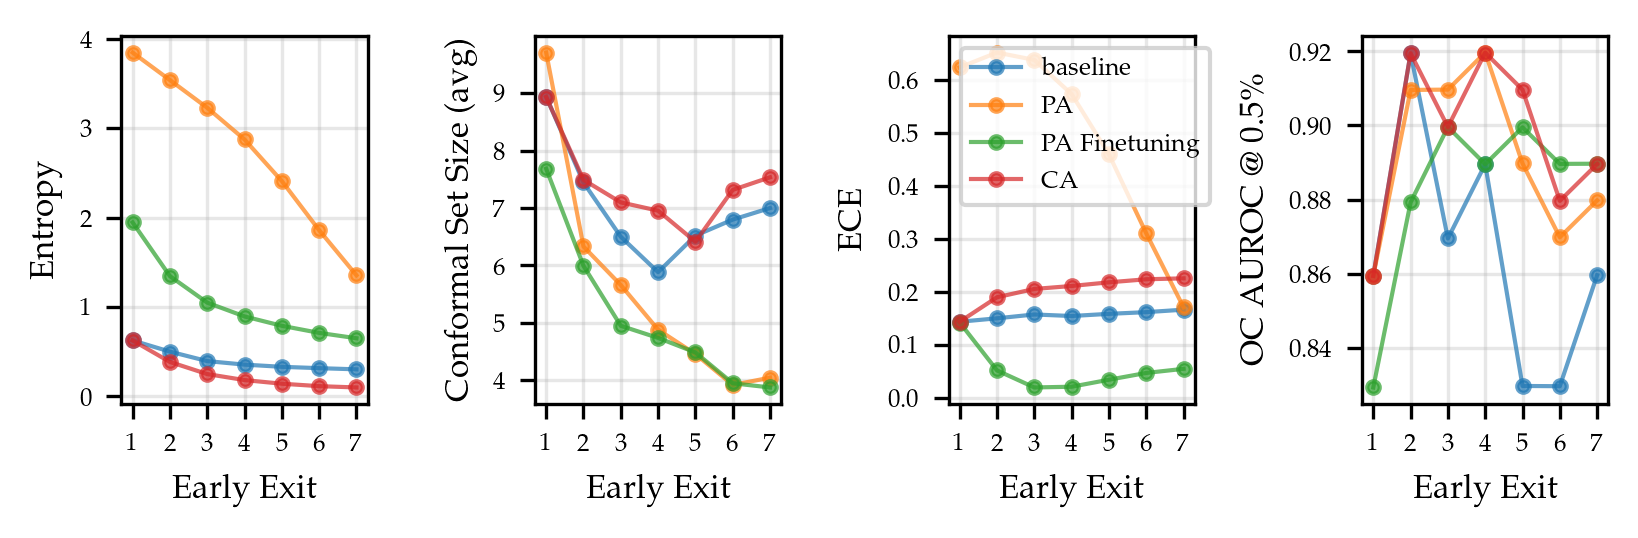

In [19]:
NAMES = [
    'baseline',
    'PA',
    # 'MSDNet PoE-OvR (tempered)',
    # 'PA (temp)',
    'PA Finetuning',
    'CA',
]
COLORS = [
    'tab:blue',
    'tab:orange',
    # 'tab:purple',
    'tab:green',
    'tab:red',
    # 'tab:purple'
]
PROBS = [
    probs,
    probs_poe_ovr_break_ties_generalized,
    # _probs_poe_ovr_break_ties_generalized_tempered,
    # _probs_poe_ovr_break_ties_generalized_tempered_multi,
    # probs_poe,
    probs_pa_softplus,
    probs_stateful,
    
]

fig, ax = plt.subplots(1, 4, figsize=(text_width, text_width * 4 / 12), sharex=True)

for _entropy, label, color in zip([entropy_baseline, entropy_poe_ovr_break_ties_generalized, 
                                   entropy_pa_softplus, entropy_stateful], NAMES, COLORS):
    ax[0].plot(list(range(1, L + 1)), _entropy.mean(axis=1), marker='o', label=label, color=color, alpha=0.7)
# ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Entropy')
ax[0].set_xlabel('Early Exit')


for _sizes, label, color in zip([sizes_conf_sets, sizes_conf_sets_poe_ovr_break_ties_generalized, 
                                 sizes_conf_sets_pa_softplus, sizes_conf_sets_stateful], NAMES, COLORS):
    ax[1].plot(list(range(1, L + 1)), _sizes, marker='o', label=label, color=color, alpha=0.7)
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel('Conformal Set Size (avg)')
ax[1].set_xticks(list(range(1, L + 1)))


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    eces = []
    eces_rm = []
    for l in range(L):
        # eces.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
        ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
        ece.add_batch(_probs[l, :, :].numpy(), label=targets.numpy())
        eces_rm.append(ece.result()['ece'])
    # ax[2].plot(list(range(1, L + 1)), eces, '-', marker='o', label=label, color=color, alpha=0.5)
    ax[2].plot(list(range(1, L + 1)), eces_rm, '-', marker='o', label=label, color=color, alpha=0.7)
# ax[2].set_xlabel('Early Exit')
ax[2].set_ylabel('ECE')
ax[2].set_xlabel('Early Exit')

FRACTION = 0.005
for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_aucs = []
    oracle0_aucs = []
    oracle100_aucs = []
    keras_oracle_aucs = []
    for l in range(L):
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle_aucs.append(oracle_auc.result()['collaborative_auc'])

    ax[3].plot(list(range(1, L + 1)), oracle_aucs, '-', marker='o',  label=label, alpha=.7, color=color)
ax[3].set_ylabel(f'OC AUROC @ {FRACTION * 100}\%')
ax[3].set_xlabel('Early Exit')

ax[2].legend()



plt.tight_layout()
# plt.savefig(f'figures/figure_uncertainty_metrics_one_row_v2.pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Figure Calibration Gap

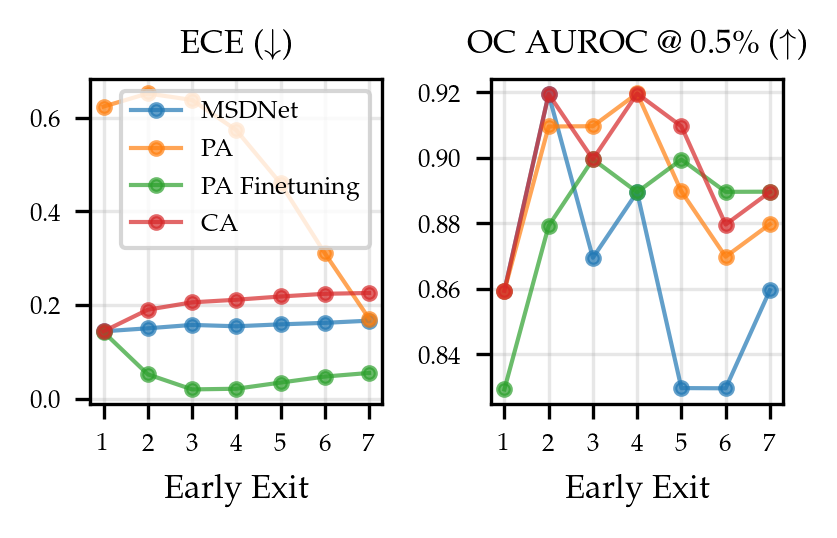

In [49]:
NAMES = [
    'MSDNet',
    'PA',
    # 'MSDNet PoE-OvR (tempered)',
    # 'PA (temp)',
    'PA Finetuning',
    'CA',
]
COLORS = [
    'tab:blue',
    'tab:orange',
    # 'tab:purple',
    'tab:green',
    'tab:red',
    # 'tab:purple'
]
PROBS = [
    probs,
    probs_poe_ovr_break_ties_generalized,
    # _probs_poe_ovr_break_ties_generalized_tempered,
    # _probs_poe_ovr_break_ties_generalized_tempered_multi,
    # probs_poe,
    probs_pa_softplus,
    probs_stateful,
    
]

fig, ax = plt.subplots(1, 2, figsize=(text_width * 0.5, text_width * 4 / 12), sharex=True)


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    eces = []
    eces_rm = []
    for l in range(L):
        # eces.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
        ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
        ece.add_batch(_probs[l, :, :].numpy(), label=targets.numpy())
        eces_rm.append(ece.result()['ece'])
    # ax[2].plot(list(range(1, L + 1)), eces, '-', marker='o', label=label, color=color, alpha=0.5)
    ax[0].plot(list(range(1, L + 1)), eces_rm, '-', marker='o', label=label, color=color, alpha=0.7)
ax[0].set_title('ECE ($\downarrow$)')
ax[0].set_xlabel('Early Exit')

FRACTION = 0.005
for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_aucs = []
    oracle0_aucs = []
    oracle100_aucs = []
    keras_oracle_aucs = []
    for l in range(L):
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle_aucs.append(oracle_auc.result()['collaborative_auc'])

    ax[1].plot(list(range(1, L + 1)), oracle_aucs, '-', marker='o',  label=label, alpha=.7, color=color)
ax[1].set_title(f"OC AUROC @ {FRACTION * 100}\\% ($\\uparrow$)")
ax[1].set_xlabel('Early Exit')

ax[0].legend()


ax[0].set_xticks(list(range(1, L + 1)))
ax[1].set_xticks(list(range(1, L + 1)))



plt.tight_layout()
plt.savefig(f'figures/figure_calibration_gap.pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [14]:
def get_calibration_with_error_bars(dataset, model_list, finetune=False):
    assert dataset in ['cifar100']

    random.seed(10)
    FRACTION = 0.005

    ece, ece_pa, ece_ca = [], [], []
    auc, auc_pa, auc_ca = [], [], []
    for _model, _epoch in model_list:
        if dataset != 'ImageNet':
            logits, targets, _ = get_logits_targets(dataset, _model, 'softmax', _epoch, cuda=True)
        else:
            raise NotImplementedError
        

        L, N = len(logits), len(targets)
        
        probs = torch.softmax(logits, dim=2)
        if finetune:
            probs_pa = torch.tensor(f_probs_pa_softplus(logits))
        else:
            probs_pa = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L)))
        
        probs_ca = anytime_caching(probs, N=N, L=L)

        
        for _probs, _list in zip([probs, probs_pa, probs_ca], [ece, ece_pa, ece_ca]):
            _eces = []
            for l in range(L):
                _ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
                _ece.add_batch(_probs[l, :, :].numpy(), label=targets.numpy())
                _eces.append(_ece.result()['ece'])
            _list.append(np.array(_eces))

        for _probs, _list in zip([probs, probs_pa, probs_ca], [auc, auc_pa, auc_ca]):
            _aucs = []
            for l in range(L):
                _preds = _probs[l, :, :].numpy().argmax(axis=-1)

                oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                                num_bins=1000)
                oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
                _aucs.append(oracle_auc.result()['collaborative_auc'])
            _list.append(np.array(_aucs))

    
    ece, ece_pa, ece_ca = np.array(ece), np.array(ece_pa), np.array(ece_ca)
    auc, auc_pa, auc_ca = np.array(auc), np.array(auc_pa), np.array(auc_ca)

    

    return (ece.mean(axis=0), ece.std(axis=0)), (ece_pa.mean(axis=0), ece_pa.std(axis=0)), (ece_ca.mean(axis=0), ece_ca.std(axis=0)), \
            (auc.mean(axis=0), auc.std(axis=0)), (auc_pa.mean(axis=0), auc_pa.std(axis=0)), (auc_ca.mean(axis=0), auc_ca.std(axis=0))

In [15]:
MODEL_NAME = 'MSDNet'
DATASET = 'cifar100'
MODEL_LIST = [('models', 298), ('models_seed_1', 299), ('models_seed_2', 299)]

ece, ece_pa, ece_ca, auc, auc_pa, auc_ca = get_calibration_with_error_bars(dataset=DATASET, model_list=MODEL_LIST)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

2023-10-26 17:47:26.063862: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-10-26 17:47:26.063954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-10-26 17:47:26.064024: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-10-26 17:47:26.064096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2023-10-26 17:47:26.064164: W tensorfl

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  ************

In [16]:
MODEL_NAME = 'MSDNet'
DATASET = 'cifar100'
MODEL_LIST = [('models_prod_softplus_finetuning_100', 299), ('models_prod_softplus_finetuning_100_seed_1', 299), ('models_prod_softplus_finetuning_100_seed_2', 299)]

_, ece_pa_finetune, _, _, auc_pa_finetune, _ = get_calibration_with_error_bars(dataset=DATASET, model_list=MODEL_LIST, finetune=True)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

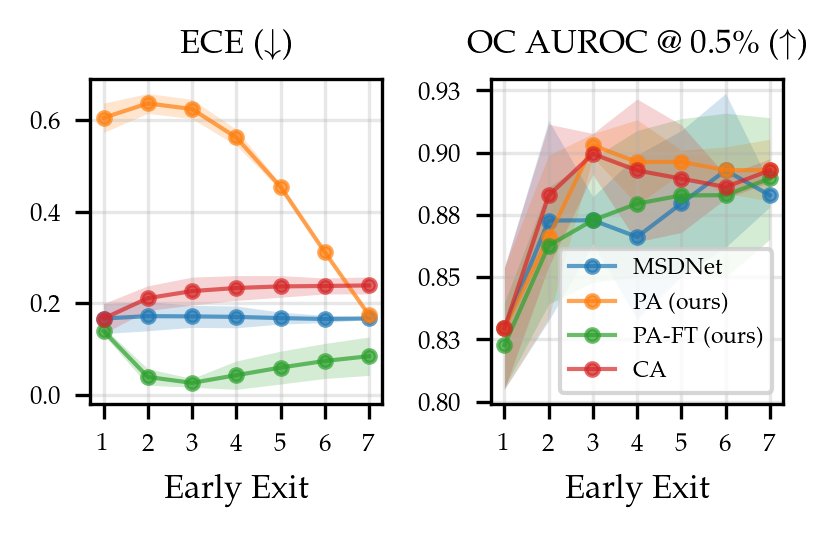

In [18]:
NAMES = [
    'MSDNet',
    'PA (ours)',
    # 'MSDNet PoE-OvR (tempered)',
    # 'PA (temp)',
    'PA-FT (ours)',
    'CA',
]
COLORS = [
    'tab:blue',
    'tab:orange',
    # 'tab:purple',
    'tab:green',
    'tab:red',
    # 'tab:purple'
]
# PROBS = [
#     probs,
#     probs_poe_ovr_break_ties_generalized,
#     # _probs_poe_ovr_break_ties_generalized_tempered,
#     # _probs_poe_ovr_break_ties_generalized_tempered_multi,
#     # probs_poe,
#     probs_pa_softplus,
#     probs_stateful,
    
# ]

FRACTION = 0.005

fig, ax = plt.subplots(1, 2, figsize=(text_width * 0.5, text_width * 4 / 12), sharex=True)


for _ece, label, color in zip([ece, ece_pa, ece_pa_finetune, ece_ca], NAMES, COLORS):
    ax[0].plot(list(range(1, L + 1)), _ece[0], '-', marker='o', label=label, color=color, alpha=0.7)
    ax[0].fill_between(list(range(1, L + 1)), _ece[0] - 2 * _ece[1], _ece[0] + 2 * _ece[1], alpha=0.2, color=color, lw=0.)
ax[0].set_title('ECE ($\downarrow$)')
ax[0].set_xlabel('Early Exit')


for _auc, label, color in zip([auc, auc_pa, auc_pa_finetune, auc_ca], NAMES, COLORS):
    ax[1].plot(list(range(1, L + 1)), _auc[0], '-', marker='o',  label=label, alpha=.7, color=color)
    ax[1].fill_between(list(range(1, L + 1)), _auc[0] - _auc[1], _auc[0] + _auc[1], alpha=0.2, color=color, lw=0.)
ax[1].set_title(f"OC AUROC @ {FRACTION * 100}\\% ($\\uparrow$)")
ax[1].set_xlabel('Early Exit')

# ax[1].legend(bbox_to_anchor=(0.13,0.53), fontsize=6)
ax[1].legend(fontsize=5.5)


ax[0].set_xticks(list(range(1, L + 1)))
ax[1].set_xticks(list(range(1, L + 1)))

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))



plt.tight_layout()
plt.savefig(f'figures/figure_calibration_gap_error_bars_v3.pdf', dpi=1200)
plt.show()

/tmp/ipykernel_66520/1672475554.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0])
/tmp/ipykernel_66520/1672475554.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[1])
/tmp/ipykernel_66520/1672475554.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[2])


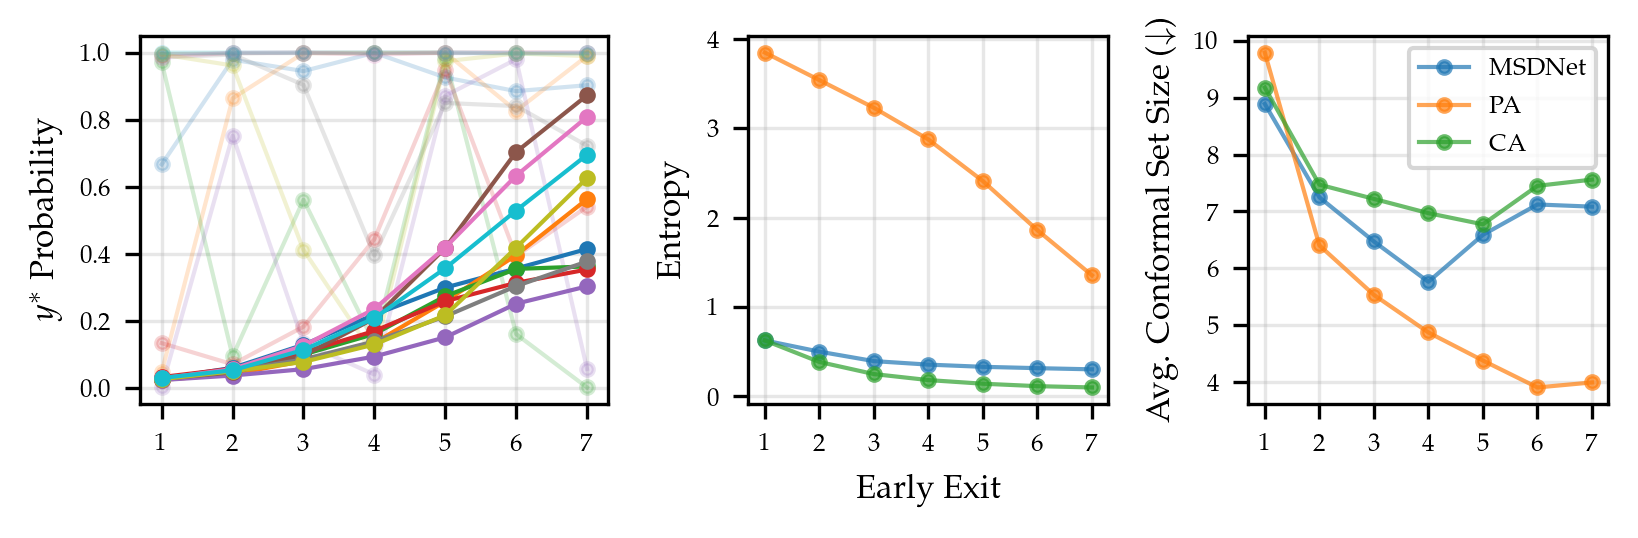

In [40]:
NAMES = [
    'MSDNet',
    'PA',
    # 'MSDNet PoE-OvR (tempered)',
    # 'PA (temp)',
    # 'PA Finetuning',
    'CA',
]
COLORS = [
    'tab:blue',
    'tab:orange',
    # 'tab:purple',
    'tab:green',
    # 'tab:red',
    # 'tab:purple'
]
PROBS = [
    probs,
    probs_poe_ovr_break_ties_generalized,
    # _probs_poe_ovr_break_ties_generalized_tempered,
    # _probs_poe_ovr_break_ties_generalized_tempered_multi,
    # probs_poe,
    # probs_pa_softplus,
    probs_stateful,
    
]

gs = GridSpec(1, 3, width_ratios=[1.3, 1, 1])
fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 4 / 12), sharex=True)


ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])


np.random.seed(40)
IDS = np.random.randint(0, 10000, 10)

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
for _probs, _label in zip([probs, probs_poe_ovr_break_ties_generalized], ['MSDNet', 'PA']):

    # ground-truth probability
    # for i in [4969, 6534]:
    for j, i in enumerate(IDS):
        probs_i = _probs[:, i, targets[i]].cpu()
        if _label == 'MSDNet':
            ax0.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', alpha=0.2, color=COLORS[j])
        else:
            ax0.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=COLORS[j])

ax0.set_ylabel('$y^*$ Probability')
ax0.set_xticks(list(range(1, L + 1)))

for _entropy, label, color in zip([entropy_baseline, entropy_poe_ovr_break_ties_generalized, 
                                   entropy_stateful], NAMES, COLORS):
    ax1.plot(list(range(1, L + 1)), _entropy.mean(axis=1), marker='o', label=label, color=color, alpha=0.7)
# ax[0].set_xlabel('Early Exit')
ax1.set_ylabel('Entropy')
ax1.set_xlabel('Early Exit')
ax1.set_xticks(list(range(1, L + 1)))


for _sizes, label, color in zip([sizes_conf_sets, sizes_conf_sets_poe_ovr_break_ties_generalized, 
                                 sizes_conf_sets_stateful], NAMES, COLORS):
    ax2.plot(list(range(1, L + 1)), _sizes, marker='o', label=label, color=color, alpha=0.7)
# ax[2].set_xlabel('Early Exit')
ax2.set_ylabel('Avg. Conformal Set Size ($\downarrow$)')
ax2.set_xticks(list(range(1, L + 1)))


ax2.legend()



plt.tight_layout()
# plt.savefig(f'figures/figure_uncertainty.pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [13]:
MODEL_NAME = 'MSDNet'
DATASET = 'cifar100'
MODEL_LIST = [('models', 298), ('models_seed_1', 299), ('models_seed_2', 299)]

ent, ent_pa, ent_ca, conf_sets, conf_sets_pa, conf_sets_ca = get_uncertainty_with_error_bars(dataset=DATASET, model_list=MODEL_LIST)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [28]:
logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)
probs = torch.softmax(logits, dim=2)

logits_a, targets_a, _ = get_logits_targets('cifar100', 'models_prod_softplus_finetuning_100', 'softmax', 299, cuda=True)
probs_pa_softplus = torch.tensor(f_probs_pa_softplus(logits_a, weights=None))

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [30]:
torch.all(targets == targets_a)

tensor(True)

/tmp/ipykernel_66520/850942703.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])
/tmp/ipykernel_66520/850942703.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[1])


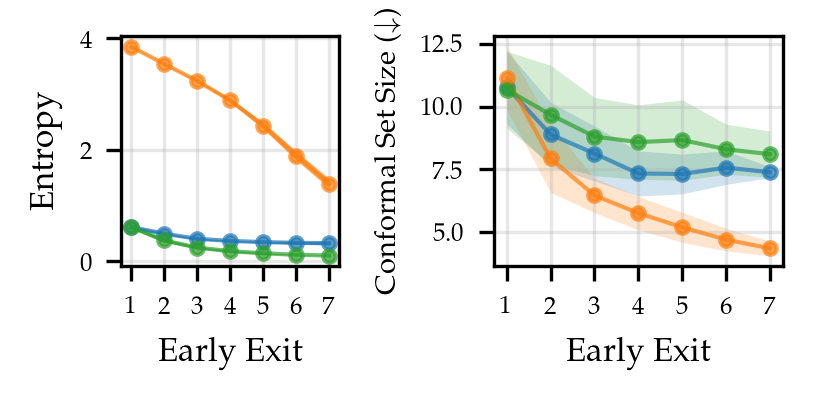

In [56]:
NAMES = [
    'MSDNet',
    'PA (ours)',
    'CA',
]
COLORS = [
    'tab:blue',
    'tab:orange',
    'tab:green',
]

# gs = GridSpec(1, 3, width_ratios=[1.3, 1, 1])
# fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 3 / 12), sharex=True)


# ax0 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[1])
# ax2 = plt.subplot(gs[2])



# gs = GridSpec(1, 1)
# fig = plt.figure(figsize=(text_width * 0.4, text_width * 0.2))

# ax0 = plt.subplot(gs[0])



gs = GridSpec(1, 2, width_ratios=[1, 1.33])
fig, ax = plt.subplots(1, 2, figsize=(text_width * 0.5, text_width * 3 / 12), sharex=True)


ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])





# np.random.seed(40)
# IDS = np.random.randint(0, 10000, 10)

# COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
# # for _probs, _label in zip([probs, probs_poe_ovr_break_ties_generalized], ['MSDNet', 'PA']):
# for _probs, _label in zip([probs, probs_pa_softplus], ['MSDNet', 'PA']):

#     # ground-truth probability
#     # for i in [4969, 6534]:
#     for j, i in enumerate(IDS):
#         probs_i = _probs[:, i, targets[i]].cpu()
#         if _label == 'MSDNet':
#             ax0.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', alpha=0.2, color=COLORS[j])
#         else:
#             ax0.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=COLORS[j])

# ax0.set_ylabel('$y^*$ Probability')
# ax0.set_xticks(list(range(1, L + 1)))
# ax0.set_yticks([0., 0.5, 1.])

for _entropy, label, color in zip([ent, ent_pa, ent_ca], NAMES, COLORS):
    # print(_entropy)
    ax1.plot(list(range(1, L + 1)), _entropy[0], marker='o', label=label, color=color, alpha=0.7)
    ax1.fill_between(list(range(1, L + 1)), _entropy[0] - 3 * _entropy[1], _entropy[0] + 3 * _entropy[1], alpha=0.7, color=color, lw=0.)
# ax[0].set_xlabel('Early Exit')
ax1.set_ylabel('Entropy')
ax1.set_xlabel('Early Exit')
ax1.set_xticks(list(range(1, L + 1)))


for _sizes, label, color in zip([conf_sets, conf_sets_pa, conf_sets_ca], NAMES, COLORS):
    ax2.plot(list(range(1, L + 1)), _sizes[0], marker='o', label=label, color=color, alpha=0.7)
    ax2.fill_between(list(range(1, L + 1)), _sizes[0] - _sizes[1], _sizes[0] + _sizes[1], alpha=0.2, color=color, lw=0.)
ax2.set_xlabel('Early Exit')
ax2.set_ylabel('Conformal Set Size ($\downarrow$)', fontsize=7)
ax2.set_xticks(list(range(1, L + 1)))


# ax1.legend(loc='best')

# fig.text(0.5, 0.04, 'Early Exit', ha='center')

plt.tight_layout()
plt.savefig(f'figures/fig_uncertainty_v3.pdf', dpi=1200, bbox_inches='tight')
plt.show()

/tmp/ipykernel_66520/184765908.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[1])


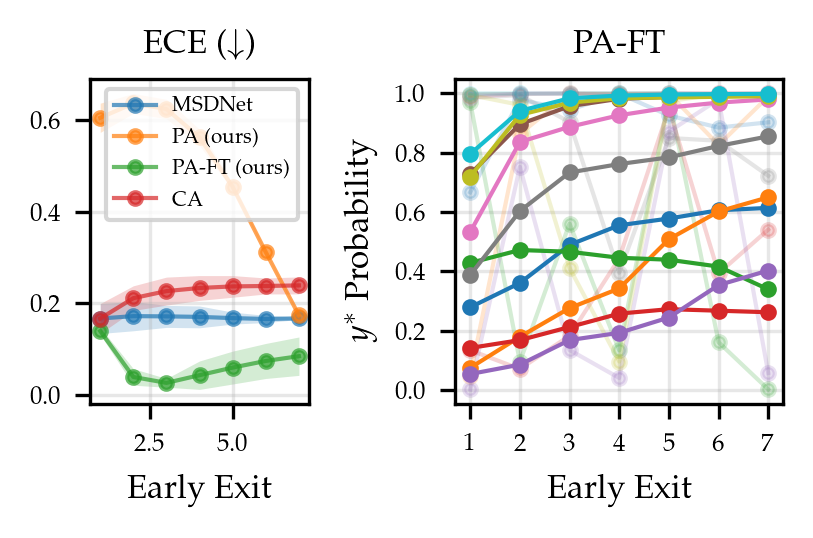

In [50]:
NAMES = [
    'MSDNet',
    'PA (ours)',
    # 'MSDNet PoE-OvR (tempered)',
    # 'PA (temp)',
    'PA-FT (ours)',
    'CA',
]
COLORS = [
    'tab:blue',
    'tab:orange',
    # 'tab:purple',
    'tab:green',
    'tab:red',
    # 'tab:purple'
]
PROBS = [
    probs,
    probs_poe_ovr_break_ties_generalized,
    # _probs_poe_ovr_break_ties_generalized_tempered,
    # _probs_poe_ovr_break_ties_generalized_tempered_multi,
    # probs_poe,
    # probs_pa_softplus,
    probs_stateful,
    
]

gs = GridSpec(1, 2, width_ratios=[1, 1.5])
fig, ax = plt.subplots(1, 1, figsize=(text_width * 0.5, text_width * 4 / 12), sharex=True)


ax0 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[0])



np.random.seed(40)
IDS = np.random.randint(0, 10000, 10)

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
for _probs, _label in zip([probs, probs_pa_softplus], ['MSDNet', 'PA']):

    # ground-truth probability
    # for i in [4969, 6534]:
    for j, i in enumerate(IDS):
        probs_i = _probs[:, i, targets[i]].cpu()
        if _label == 'MSDNet':
            ax0.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', alpha=0.2, color=COLORS[j])
        else:
            ax0.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=COLORS[j])

ax0.set_ylabel('$y^*$ Probability')
ax0.set_xticks(list(range(1, L + 1)))
ax0.set_xlabel('Early Exit')
ax0.set_title('PA-FT')


ax2.legend()

for _ece, label, color in zip([ece, ece_pa, ece_pa_finetune, ece_ca], NAMES, COLORS):
    ax3.plot(list(range(1, L + 1)), _ece[0], '-', marker='o', label=label, color=color, alpha=0.7)
    ax3.fill_between(list(range(1, L + 1)), _ece[0] - 2 * _ece[1], _ece[0] + 2 * _ece[1], alpha=0.2, color=color, lw=0.)
ax3.set_title('ECE ($\downarrow$)')
ax3.set_xlabel('Early Exit')
ax3.legend(fontsize=5)




plt.tight_layout()
plt.savefig(f'figures/figure_calib_gap_v3.pdf', dpi=1200, bbox_inches='tight')
plt.show()

baseline {0.01: 66.95, 0.05: 55.589999999999996, 0.1: 48.94, 0.2: 40.39, 0.5: 19.79}
PoE-OvR {0.01: 0.5599999999999999, 0.05: 0.0, 0.1: 0.0, 0.2: 0.0, 0.5: 0.0}
PoE-OvR (temp) {0.01: 9.610000000000001, 0.05: 2.03, 0.1: 0.38999999999999996, 0.2: 0.02, 0.5: 0.0}
PoE-softmax {0.01: 38.25, 0.05: 23.78, 0.1: 15.260000000000002, 0.2: 6.92, 0.5: 0.5599999999999999}


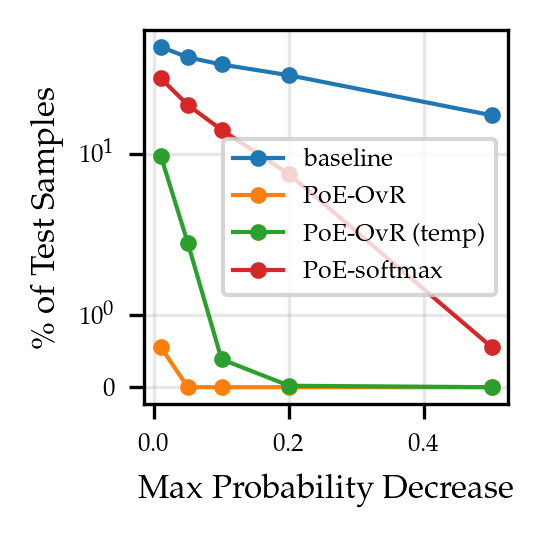

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(text_width/3, text_width/3))

for _probs, label, color in zip(PROBS, NAMES, COLORS):
    preds = probs.argmax(dim=-1)
    modal_probs = modal_probs_decreasing(preds, _probs, L, N=N)
    print(label, modal_probs)

    ax.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label, color=color, alpha=1)

ax.set_xlabel('Max Probability Decrease')
ax.set_ylabel('\% of Test Samples')
ax.legend()
# set log scale
ax.set_yscale('symlog')

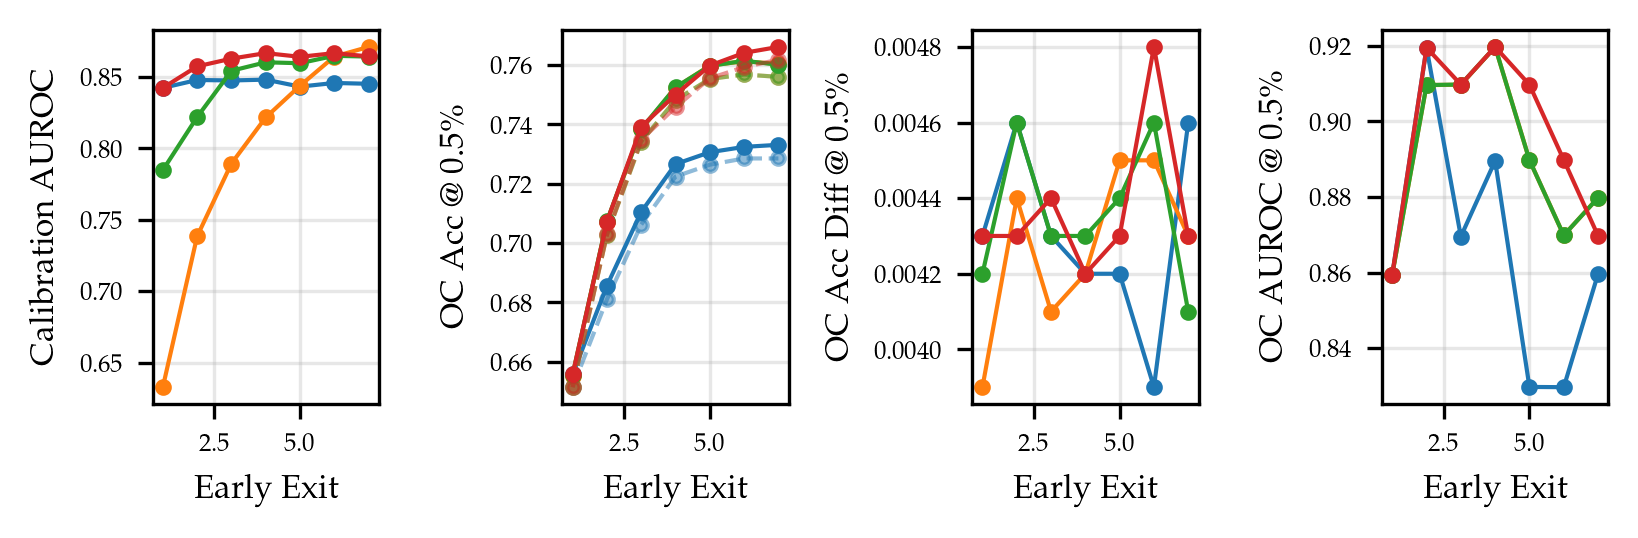

In [16]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

# NAMES = ['MSDNet', 'MSDNet PoE-OvR', 'MSDNet PoE-OvR (tempered)', 'MSDNet PoE-softmax']

fig, ax = plt.subplots(1, 4, figsize=(text_width, text_width / 3))

for _probs, label, color in zip(PROBS, NAMES, COLORS):
    calib_aucs = []
    for l in range(L):
        calib_auc = rm.metrics.CalibrationAUC(correct_pred_as_pos_label=False, curve='ROC')
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)
        calib_auc.add_batch(_preds, label=targets.numpy(), confidence=_probs[l, :, :].numpy().max(axis=-1))
        calib_aucs.append(calib_auc.result()['calibration_auc'])
    ax[0].plot(list(range(1, L + 1)), calib_aucs, marker='o', label=label, color=color)
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Calibration AUROC')
# ax[0].legend()




FRACTION = 0.005


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_accs = []
    accs = []
    for l in range(L):
        oracle_accs.append(oracle_collab_acc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy().max(axis=-1), 
            FRACTION, 
            diff=False))
        accs.append(oracle_collab_acc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy().max(axis=-1),
            0.,
            diff=False))

    ax[1].plot(list(range(1, L + 1)), oracle_accs, marker='o', label=label, color=color, alpha=1)
    ax[1].plot(list(range(1, L + 1)), accs, '--', marker='o', label=label, color=color, alpha=0.5)
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel(f'OC Acc @ {FRACTION * 100}\%')
# create legend to compare the two lines: solid (oracle colaborative) and dashed (baseline)
# ax[1].legend([
#     matplotlib.lines.Line2D([0], [0], color='black', lw=1, linestyle='-', alpha=1),
#     matplotlib.lines.Line2D([0], [0], color='black', lw=1, linestyle='--', alpha=0.5)],
#     ['Oracle Collaborative', 'Baseline']
#     )


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_accs = []
    for l in range(L):
        oracle_accs.append(oracle_collab_acc_np(
            _probs[l, :, :].numpy().argmax(axis=-1),
            targets.numpy(),
            _probs[l, :, :].numpy().max(axis=-1), 
            FRACTION, 
            diff=True))

    ax[2].plot(list(range(1, L + 1)), oracle_accs, marker='o', label=label, color=color, alpha=1)
ax[2].set_xlabel('Early Exit')
ax[2].set_ylabel(f'OC Acc Diff @ {FRACTION * 100}\%')



FRACTION = 0.005

for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_aucs = []
    oracle0_aucs = []
    oracle100_aucs = []
    keras_oracle_aucs = []
    for l in range(L):
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle_aucs.append(oracle_auc.result()['collaborative_auc'])

    ax[3].plot(list(range(1, L + 1)), oracle_aucs, '-', marker='o',  label=label, alpha=1., color=color)
ax[3].set_xlabel('Early Exit')
ax[3].set_ylabel(f'OC AUROC @ {FRACTION * 100}\%')



plt.tight_layout()
plt.savefig(f'figures/figure_4b.pdf', dpi=1200)
plt.show()

In [17]:
svhn_ood_logits, _, _ = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, ood_dataset='svhn')
cifar10_ood_logits, _, _ = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, ood_dataset='cifar10')

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [18]:
# baseline scores
svhn_ood_probs = torch.softmax(svhn_ood_logits, dim=2)
cifar10_ood_probs = torch.softmax(cifar10_ood_logits, dim=2)

(_, msp_baseline) = get_ood_scores(probs) # entropy baseline is already calculated
(cifar10_ood_entropy_baseline, cifar10_ood_msp_baseline) = get_ood_scores(cifar10_ood_probs)
(svhn_ood_entropy_baseline, svhn_ood_msp_baseline) = get_ood_scores(svhn_ood_probs)


# PoE scores
svhn_ood_probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(svhn_ood_logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
cifar10_ood_probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(cifar10_ood_logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))

(_, msp_poe_ovr_break_ties_generalized) = get_ood_scores(probs_poe_ovr_break_ties_generalized)
(cifar10_ood_entropy_poe_ovr_break_ties_generalized, cifar10_ood_msp_poe_ovr_break_ties_generalized) = get_ood_scores(cifar10_ood_probs_poe_ovr_break_ties_generalized)
(svhn_ood_entropy_poe_ovr_break_ties_generalized, svhn_ood_msp_poe_ovr_break_ties_generalized) = get_ood_scores(svhn_ood_probs_poe_ovr_break_ties_generalized)

# PoE tempered scores
svhn_ood_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(svhn_ood_probs_poe_ovr_break_ties_generalized, .5)
cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(cifar10_ood_probs_poe_ovr_break_ties_generalized, .5)

(_, msp_poe_ovr_break_ties_generalized_tempered) = get_ood_scores(_probs_poe_ovr_break_ties_generalized_tempered)
(cifar10_ood_entropy_poe_ovr_break_ties_generalized_tempered, cifar10_ood_msp_poe_ovr_break_ties_generalized_tempered) = get_ood_scores(cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered)
(svhn_ood_entropy_poe_ovr_break_ties_generalized_tempered, svhn_ood_msp_poe_ovr_break_ties_generalized_tempered) = get_ood_scores(svhn_ood_probs_poe_ovr_break_ties_generalized_tempered)

# PoE tempered multi scores
svhn_ood_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(svhn_ood_probs_poe_ovr_break_ties_generalized, np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None])
cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(cifar10_ood_probs_poe_ovr_break_ties_generalized, np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None])

(_, msp_poe_ovr_break_ties_generalized_tempered_multi) = get_ood_scores(_probs_poe_ovr_break_ties_generalized_tempered_multi)
(cifar10_ood_entropy_poe_ovr_break_ties_generalized_tempered_multi, cifar10_ood_msp_poe_ovr_break_ties_generalized_tempered_multi) = get_ood_scores(cifar10_ood_probs_poe_ovr_break_ties_generalized_tempered_multi)
(svhn_ood_entropy_poe_ovr_break_ties_generalized_tempered_multi, svhn_ood_msp_poe_ovr_break_ties_generalized_tempered_multi) = get_ood_scores(svhn_ood_probs_poe_ovr_break_ties_generalized_tempered_multi)

# PoE softmax scores
svhn_ood_logits_poe = svhn_ood_logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
svhn_ood_probs_poe = torch.softmax(svhn_ood_logits_poe, dim=2)

cifar10_ood_logits_poe = cifar10_ood_logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
cifar10_ood_probs_poe = torch.softmax(cifar10_ood_logits_poe, dim=2)

(_, msp_poe) = get_ood_scores(probs_poe)
(cifar10_ood_entropy_poe, cifar10_ood_msp_poe) = get_ood_scores(cifar10_ood_probs_poe)
(svhn_ood_entropy_poe, svhn_ood_msp_poe) = get_ood_scores(svhn_ood_probs_poe)

In [19]:
svhn_ood_entropy_baseline.shape

(7, 26032)

In [20]:
entropy_baseline.shape

(7, 10000)

In [29]:

# calculate the AUCs
ood_aucs = {
    'baseline': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}},
    'poe_ovr_break_ties_generalized': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}},
    'poe_ovr_break_ties_generalized_tempered': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}},
    'poe_ovr_break_ties_generalized_tempered_multi': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}},
    'poe': {'cifar10': {'entropy': [], 'msp': []}, 'svhn': {'entropy': [], 'msp': []}}
}

for method in ood_aucs:
    for dataset in ood_aucs[method]:
        for score in ood_aucs[method][dataset]:
            for i in range(0, L):
                mul = -1 if score == 'msp' else 1
                id_score = eval('{}_{}'.format(score, method))[i]
                ood_score = eval('{}_ood_{}_{}'.format(dataset, score, method))[i]
                ood_aucs[method][dataset][score].append(get_ood_detection_roc(mul * id_score, mul * ood_score)[2])

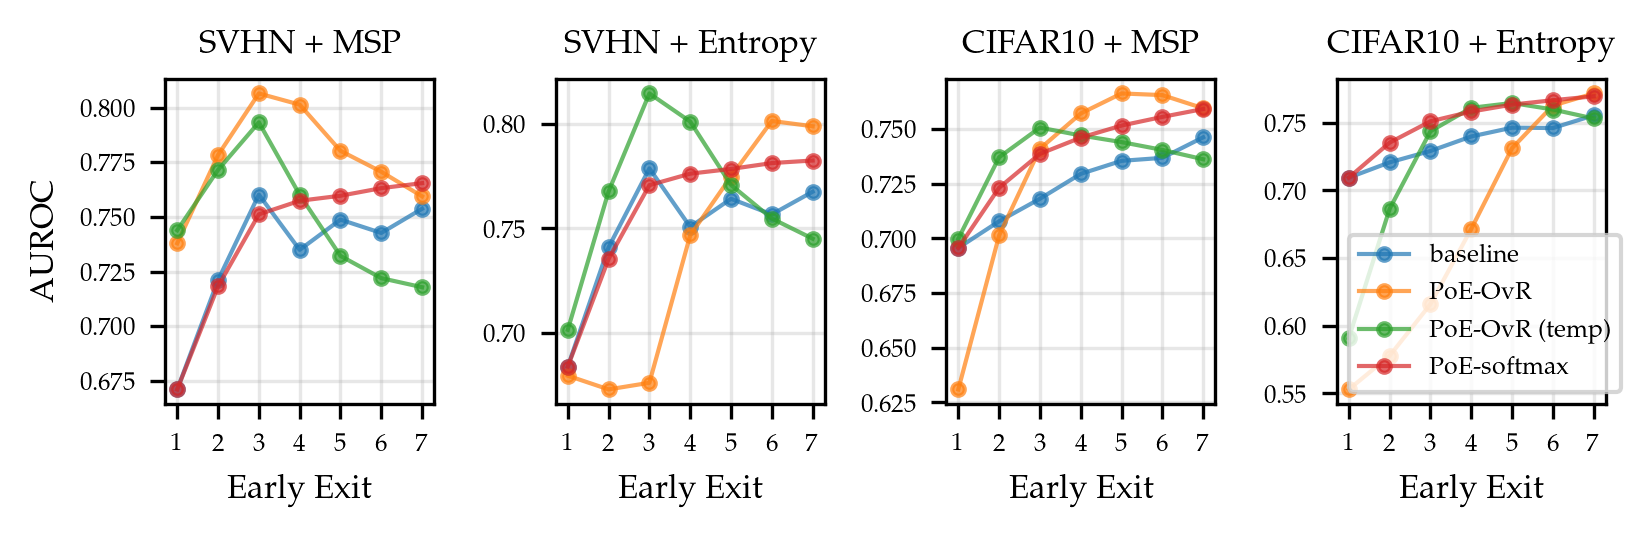

In [43]:
# make plots showing the OOD results. We will have 4 plots showing all the combinations of datasets (SVHN and CIFAR10)
# and OOD scores (entropy, MSP). Each plot will have 5 lines, one for each of the 5 methods (baseline, PoE, PoE tempered, PoE softmax, PoE tempered multi)

NAMES = [
    'baseline',
    'PoE-OvR',
    # 'PoE-OvR (single temp)',
    'PoE-OvR (temp)',
    'PoE-softmax',
]
COLORS = [
    'tab:blue',
    'tab:orange',
    # 'tab:purple',
    'tab:green',
    'tab:red',
]
AUCS = [
    ood_aucs['baseline'],
    ood_aucs['poe_ovr_break_ties_generalized'],
    # ood_aucs['poe_ovr_break_ties_generalized_tempered'],
    ood_aucs['poe_ovr_break_ties_generalized_tempered_multi'],
    ood_aucs['poe'],
]

fig, ax = plt.subplots(1, 4, figsize=(text_width, text_width / 3), sharex=True)

# SVHN + MSP
for name, color, aucs in zip(NAMES, COLORS, AUCS):
    ax[0].plot(np.arange(1, L + 1), aucs['svhn']['msp'], color=color, label=name, marker='o', alpha=0.7)
ax[0].set_title('SVHN + MSP')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('AUROC')
# ax[0].legend()
ax[0].set_xticks(np.arange(1, L + 1))

# SVHN + entropy
for name, color, aucs in zip(NAMES, COLORS, AUCS):
    ax[1].plot(np.arange(1, L + 1), aucs['svhn']['entropy'], color=color, label=name, marker='o', alpha=0.7)
ax[1].set_title('SVHN + Entropy')
ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel('AUROC')


# CIFAR10 + MSP
for name, color, aucs in zip(NAMES, COLORS, AUCS):
    ax[2].plot(np.arange(1, L + 1), aucs['cifar10']['msp'], color=color, label=name, marker='o', alpha=0.7)
ax[2].set_title('CIFAR10 + MSP')
ax[2].set_xlabel('Early Exit')
# ax[2].set_ylabel('AUROC')

# CIFAR10 + entropy
for name, color, aucs in zip(NAMES, COLORS, AUCS):
    ax[3].plot(np.arange(1, L + 1), aucs['cifar10']['entropy'], color=color, label=name, marker='o', alpha=0.7)
ax[3].set_title('CIFAR10 + Entropy')
ax[3].set_xlabel('Early Exit')
# ax[3].set_ylabel('AUROC')

ax[3].legend()

plt.tight_layout()
# plt.savefig(f'figures/figure_4b.pdf', dpi=1200)
plt.show()

## Paper Plot

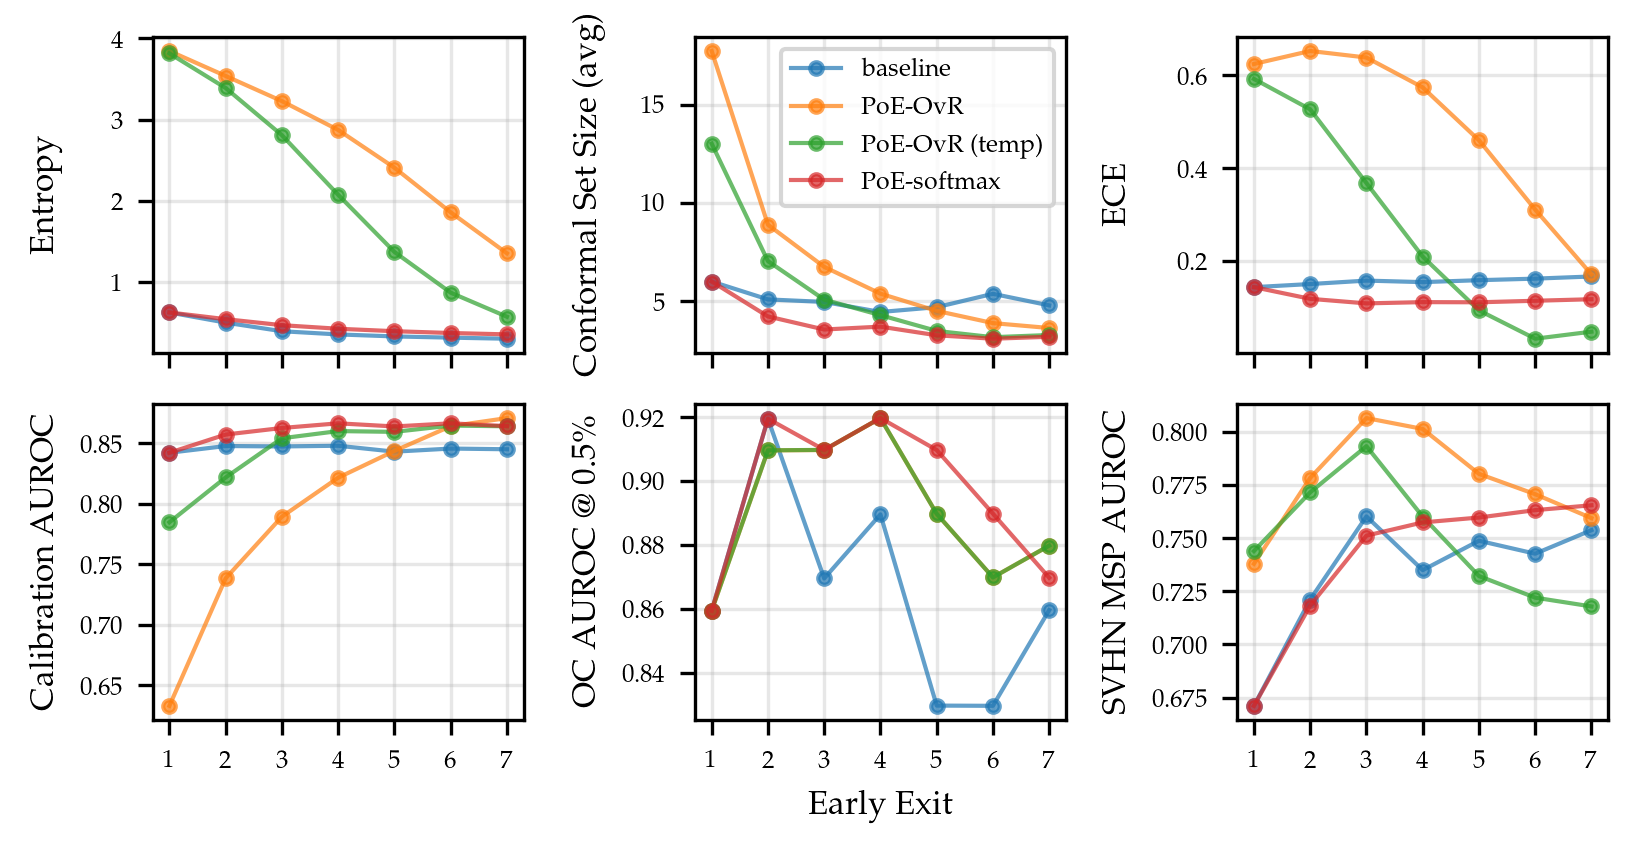

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(text_width, text_width * 0.525), sharex=True)

for _entropy, label, color in zip([entropy_baseline, entropy_poe_ovr_break_ties_generalized, entropy_poe_ovr_break_ties_generalized_tempered, entropy_poe, entropy_poe_ovr_break_ties_generalized_tempered_multi], NAMES, COLORS):
    ax[0, 0].plot(list(range(1, L + 1)), _entropy.mean(axis=1), marker='o', label=label, color=color, alpha=0.7)
ax[0, 0].set_ylabel('Entropy')


for _sizes, label, color in zip([sizes_conf_sets, sizes_conf_sets_poe_ovr_break_ties_generalized, sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, sizes_conf_sets_poe, sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi], NAMES, COLORS):
    ax[0, 1].plot(list(range(1, L + 1)), _sizes, marker='o', label=label, color=color, alpha=0.7)
ax[0, 1].set_ylabel('Conformal Set Size (avg)')
ax[0, 1].set_xticks(list(range(1, L + 1)))


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    eces = []
    eces_rm = []
    for l in range(L):
        ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
        ece.add_batch(_probs[l, :, :].numpy(), label=targets.numpy())
        eces_rm.append(ece.result()['ece'])
    ax[0, 2].plot(list(range(1, L + 1)), eces_rm, '-', marker='o', label=label, color=color, alpha=0.7)
ax[0, 2].set_ylabel('ECE')


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    calib_aucs = []
    for l in range(L):
        calib_auc = rm.metrics.CalibrationAUC(correct_pred_as_pos_label=False, curve='ROC')
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)
        calib_auc.add_batch(_preds, label=targets.numpy(), confidence=_probs[l, :, :].numpy().max(axis=-1))
        calib_aucs.append(calib_auc.result()['calibration_auc'])
    ax[1, 0].plot(list(range(1, L + 1)), calib_aucs, marker='o', label=label, color=color, alpha=0.7)
ax[1, 0].set_ylabel('Calibration AUROC')


FRACTION = 0.005
for _probs, label, color in zip(PROBS, NAMES, COLORS):
    oracle_aucs = []
    oracle0_aucs = []
    oracle100_aucs = []
    keras_oracle_aucs = []
    for l in range(L):
        _preds = _probs[l, :, :].numpy().argmax(axis=-1)

        oracle_auc = rm.metrics.OracleCollaborativeAUC(oracle_fraction=FRACTION,
                                                        num_bins=1000)
        oracle_auc.add_batch(_preds, label=targets.numpy(), custom_binning_score=_probs[l, :, :].numpy().max(axis=-1))
        oracle_aucs.append(oracle_auc.result()['collaborative_auc'])

    ax[1, 1].plot(list(range(1, L + 1)), oracle_aucs, '-', marker='o',  label=label, alpha=.7, color=color)
ax[1, 1].set_ylabel(f'OC AUROC @ {FRACTION * 100}\%')


for name, color, aucs in zip(NAMES, COLORS, AUCS):
    ax[1, 2].plot(np.arange(1, L + 1), aucs['svhn']['msp'], color=color, label=name, marker='o', alpha=0.7)
ax[1, 2].set_ylabel('SVHN MSP AUROC')


ax[0, 1].legend()
ax[1, 1].set_xlabel('Early Exit')

fig.align_ylabels(ax)


plt.tight_layout()
plt.savefig(f'figures/figure_4_paper.pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Corrupted Cifar10